In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import walk
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random
import wandb

In [2]:
wandb.init(project='one_shot_demo')
wandb.init(config={"epochs": 20, "batch_size": 64})

W&B Run: https://app.wandb.ai/kmmbd/one_shot_demo/runs/2cnq7c0w

Get training set:

In [3]:
class OmniglotDataset(Dataset):
    def __init__(self, categories, root_dir, setSize, transform = None):
        self.categories = categories
        self.root_dir = root_dir
        self.setSize = setSize
        self.transform = transform
        
    def __len__(self):
        return self.setSize
    
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label1 = None
        if idx % 2 == 0: # select same character
            category = random.choice(categories)
            character = random.choice(category[1])
            imgDir = root_dir + category[0] + '/' + character
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)
            label = 1.0 # assign label as true
            
        else: # select different characters 
            category1, category2 = random.choice(categories), random.choice(categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            imgDir1 = root_dir + category1[0] + '/' + character1
            imgDir2 = root_dir + category2[0] + '/' + character2
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0 # assign label as false 
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
            
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

Get test set:

In [4]:
class NWayOneShotEvalSet(Dataset):
    
    def __init__(self, categories, root_dir, setSize, numWay, transform = None):
        self.categories = categories
        self.root_dir = root_dir
        self.setSize = setSize
        self.numWay = numWay
        self.transform = transform
        
    def __len__(self):
        return self.setSize
    
    def __getitem__(self, idx):
        # find one main image
        category = random.choice(categories)
        character = random.choice(categories[1])
        imgDir = root_dir + category[0] + '/' + character
        imgName = random.choice(os.listdir(imgDir))
        mainImg = Image.open(imgDir + '/' + imgName)
        if self.transform:
            mainImg = self.transform(mainImg)
            
        # find n numbers of distinct images, 1 in same set as main
        testSet = []
        label = np.random.randint(self.numWay)
        for i in range(self.numWay):
            testImgDir = imgDir
            testImgName = ''
            if i == label:
                testImgName = random.choice(os.listdir(imgDir))
            else:
                testCategory = random.choice(categories)
                testCharacter = random.choice(testCategory[1])
                testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                while testImgDir == imgDir:
                    testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                testImgName = random.choice(os.listdir(testImgDir))
            
            testImg = Image.open(testImgDir + '/' + testImgName)
            if self.transform:
                testImg = self.transform(testImg)
                
            testSet.append(testImg)
        
        return mainImg, testSet, torch.from_numpy(np.array([label], dytpe = int))

build the net

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
        
    def convs(self, x):
        # out_dim = in_dim - kernel_size + 1
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.bn4(self.conv4(x)))
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256*6*6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256*6*6)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

Start training

In [6]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        wandb.log({'epoch': epoch, 'train_loss': avg_train_loss})
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        wandb.log({'epoch': epoch, 'validation_loss': loss})
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label in test_loader:
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg)
                if output > predVal:
                    pred = i
                    predVal = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))

Set dataset directory

In [7]:
root_dir = './images_background/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]
# print(categories)


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


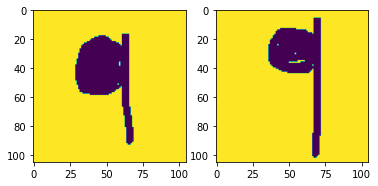

In [8]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 10000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

transformations = transforms.Compose(
    [transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, dataSize, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=0, shuffle=True)

# create the test set for final testing
testSize = 5000 
numWay = 20
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 0, shuffle=True)

count0 = 0
count1 = 0
for img1, img2, label in train_loader:
    print()
    if label[0] == 1.0:
        print(img1[0])
        plt.subplot(1,2,1)
        plt.imshow(img1[0][0])
        plt.subplot(1,2,2)
        plt.imshow(img2[0][0])
        # print(label)
        break

In [ ]:
#show for test input
count = 0
for mainImg, imgset, label in test_loader:
    # print(len(imgset))
    # print(label)
    # print(imgset.shape)
    if label != 1:
        for count, img in enumerate(imgset):
            plt.subplot(1, len(imgset)+1, count+1)
            plt.imshow(img[0][0])
          # print(img.shape)
        print(mainImg.shape)
        plt.subplot(1, len(imgset)+1, len(imgset)+1)
        plt.imshow(mainImg[0][0])
        count += 1
        break

In [9]:
#creating the original network and couting the paramenters of different networks

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
# print(dir(torch.nn))
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseBaseLine)

cuda:0
1.5.0
The model architecture:

 Net(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 38,952,897 trainable parameters


In [10]:
# save and load checkpoints

def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [ ]:
# start training

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.0006)
num_epochs = 20
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet-batchnorm50.pt'
wandb.watch(siameseBaseLine)
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/20],Train Loss: 0.5459, Valid Loss: 0.46156218
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 2
Epoch [2/20],Train Loss: 0.4484, Valid Loss: 0.41039874
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 3
Epoch [3/20],Train Loss: 0.3863, Valid Loss: 0.33398706
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 4
Epoch [4/20],Train Loss: 0.3495, Valid Loss: 0.33111261
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 5
Epoch [5/20],Train Loss: 0.3235, Valid Loss: 0.31446364
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 6
Epoch [6/20],Train Loss: 0.3017, Valid Loss: 0.31469410
Starting epoch 7
Epoch [7/20],Train Loss: 0.2977, Valid Loss: 0.28499631
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 8
Epoch [8/20],Train Loss: 0.2777, Valid Loss: 0.27618047
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 9
Epoch [9/20],Train Loss: 0.2655, Valid Loss: 0.24904275
Model saved to ==> siameseNe